# Toric Code

This notebook shows how to implement Kitaev's Toric Code model on an infinite cylinder geometry. 
The Hamiltonian of the Toric Code is:

$$\mathcal{H}=-\sum_p B_p - \sum_s A_s$$ 

where $B_p = \prod_{i \in p} \sigma^z_i$ denotes the product of $\sigma^z$ around an elementary plaquette and $A_s = \prod_{i \in s} \sigma^x_i$ denotes the product of $\sigma^x$ on the four links sticking out of a site of the lattice. The $B_p$ and $A_s$ operators commute with each other and have eigenvalues $\pm 1$, hence the ground state will have eigenvalue $+1$ for each of them.

On an infinite cylinder, the model exhibits a four-fold degeneracy of the ground state, characterized by the 
different values $\pm 1$ of the incontractible Wilson and t'Hooft loops.
These loop operators are defined by the products

$$W=\prod_{\text{vert links}} \sigma^z\qquad \qquad H=\prod_{\text{hor links}} \sigma^x$$

around the cylinder.

TeNPy already implements this hamiltonian in `tenpy.models.toric_code.ToricCode`.
This notebook demonstrates how to extend the existing model by additinoal terms in the Hamiltonian
and convenient functions of the loop operators for simplified measurements.
Then we run iDMRG to obtain the four different ground states and check that they are indeed orthogonal and degenerate.


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=120)
plt.rcParams['figure.dpi'] = 150

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms.dmrg import TwoSiteDMRGEngine
from tenpy.networks.mps import MPS
from tenpy.networks.terms import TermList
from tenpy.models.toric_code import ToricCode, DualSquare
from tenpy.models.lattice import Square

tenpy.tools.misc.setup_logging(to_stdout="WARNING")  # don't show info text

Let's plot the DualSquare lattice first to get the geometry clear. The unit cell consists of two sites, the blue one on the vertical links ($u=0$), and the orange one on the horizontal links ($u=1$).
We also plot lines illustrating where the Wilson and t'Hooft loops go.

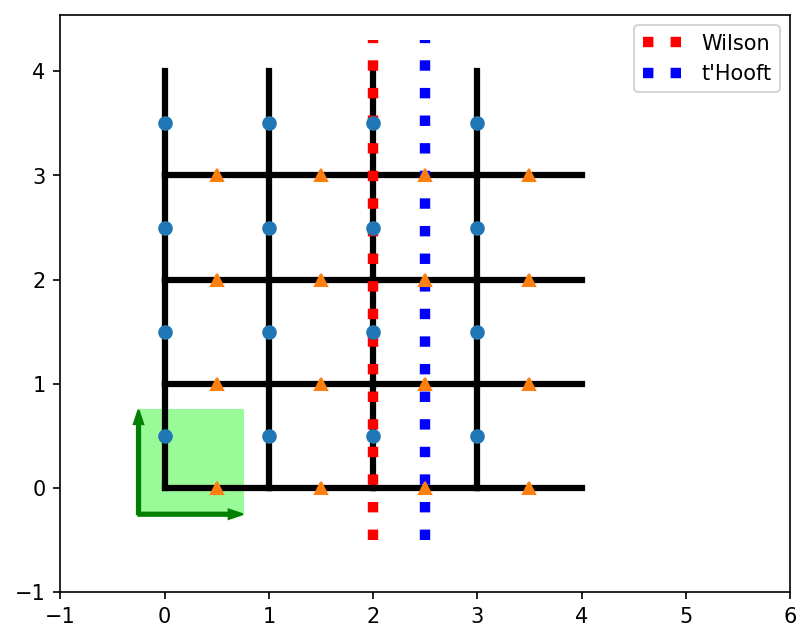

In [3]:
plt.figure(figsize=(7, 5))
ax = plt.gca()
lat = DualSquare(4, 4, None, bc='periodic')
sq = Square(4, 4, None, bc='periodic')
sq.plot_coupling(ax, linewidth=3.)
ax.plot([2., 2.], [-0.5, 4.3],  'r:', linewidth=5., label="Wilson")
ax.plot([2.5, 2.5], [-0.5, 4.3], 'b:', linewidth=5., label="t'Hooft")
lat.plot_sites(ax)
lat.plot_basis(ax, origin=-0.25*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
ax.set_xlim(-1, 6)
ax.set_ylim(-1)
ax.legend()
plt.show()

## Extending the existing model


We will implement additional parameters which allow to optionally add terms for the Wilson and t'Hooft loop operators $W, H$ defined above, $$ H \rightarrow H - \mathtt{J_{WL}} W -  \mathtt{J_{HL}} H $$

Note that here we only want to add a single loop for each of them, not one at each possible starting point. Hence, we use the method `add_local_term`, not `add_multi_coupling_term` or `add_coupling_term`. (In the case of infinite MPS, it will still be one loop per MPS unit cell, but that's okay as well.)

The sign of $\mathtt{J_{WL}},\mathtt{J_{HL}}$ will allow us to select sectors with $\langle \psi | W |\psi \rangle = \pm 1$ and $\langle \psi | H |\psi \rangle = \pm 1$, respectively.
Note that so far the constraints commute with the Hamiltonian and with each other.
However, this is no longer the case if we add another global field  $H \rightarrow H -\mathtt{h} \sum_i \sigma^z_i$, which makes the Hamiltonian no longer exactly solvable.

In [4]:
class ExtendedToricCode(ToricCode):

    def init_terms(self, model_params):
        ToricCode.init_terms(self, model_params)  # add terms of the original ToricCode model
        
        Ly = self.lat.shape[1]
        J_WL = model_params.get('J_WL', 0.)
        J_HL = model_params.get('J_HL', 0.)
        # unit-cell indices:
        # u=0: vertical links
        # u=1: horizontal links
       
        # Wilson Loop
        x, u = 0, 0 # vertical links
        self.add_local_term(-J_WL, [('Sigmaz', [x, y, u]) for y in range(Ly)])

        # t'Hooft Loop
        x, u = 0, 1 # horizontal links
        self.add_local_term(-J_HL, [('Sigmax', [x, y, u]) for y in range(Ly)])
            
        h = model_params.get('h', 0.)
        for u in range(2):
            self.add_onsite(-h, u, 'Sigmaz')
        
    def wilson_loop_y(self, psi):
        """Measure wilson loop around the cylinder."""
        Ly = self.lat.shape[1]
        x, u = 0, 0 # vertical links
        W = TermList.from_lattice_locations(self.lat, [[("Sigmaz",[x, y, u]) for y in range(Ly)]])
        return psi.expectation_value_terms_sum(W)[0]
    
    def hooft_loop_y(self, psi):
        """Measure t'Hooft loop around the cylinder."""
        Ly = self.lat.shape[1]
        x, u = 0, 1 # horizontal links
        H = TermList.from_lattice_locations(self.lat, [[("Sigmax",[x, y, u]) for y in range(Ly)]])
        return psi.expectation_value_terms_sum(H)[0]
    

## iDMRG
We now run the iDMRG algorithm for the four different sectors to obtain the four degenerate ground states of the system. 

To reliably get the 4 different ground states, we will add the energetic constraints for the loops.
In this case, the original Hamiltonian will completely commute with the loop operators, such that you directly get the correct ground state. However, this is a very peculiar case - in general, e.g. when you add the external field with $h \neq 0$, this will no longer be the case.
We hence demonstrate a more "robust" way of getting the four different ground states (at least if you have an idea which operator distinguishes them): 
For each sector, we run DMRG twice: first with the energy penalties for the $W,H$ loops to get an initial $|\psi\rangle$ in the desired sector. Then we run DMRG again for the clean toric code model, without the $W,H$ added, to make sure we have a ground state of the clean model.

In [5]:
dmrg_params = {
    'mixer': True,
    'trunc_params': {'chi_max': 64, 
                     'svd_min': 1.e-8},
    'max_E_err': 1.e-8,
    'max_S_err': 1.e-7,
    'N_sweeps_check': 4,
    'max_sweeps':24,
}
model_params = {
    'Lx': 1, 'Ly': 4, # Ly is set below
    'bc_MPS': "infinite",
    'conserve': None,
}


def run_DMRG(Ly, J_WL, J_HL, Jv, Jp, h=0.):
    print("="*80)
    print(f"Start iDMRG for Ly={Ly:d}, J_WL={J_WL:.2f}, J_HL={J_HL:.2f}, h={h:.2f}")
    model_params_clean = model_params.copy()
    model_params_clean['Ly'] = Ly
    model_params_clean['h'] = h
    model_params_clean['Jv'] = Jv
    model_params_clean['Jp'] = Jp
    model_clean = ExtendedToricCode(model_params_clean)
    model_params_seed = model_params_clean.copy()
    model_params_seed['J_WL'] = J_WL
    model_params_seed['J_HL'] = J_HL
    model_params_seed['Jv'] = Jv
    model_params_seed['Jp'] = Jp    
    model = ExtendedToricCode(model_params_seed)
    psi = MPS.from_lat_product_state(model.lat, [[["up"]]])

    eng = TwoSiteDMRGEngine(psi, model, dmrg_params)
    E0, psi = eng.run()
    WL = model.wilson_loop_y(psi)
    HL = model.hooft_loop_y(psi)
    print(f"after first DMRG run: <psi|W|psi> = {WL: .3f}")
    print(f"after first DMRG run: <psi|H|psi> = {HL: .3f}")
    print(f"after first DMRG run: E (including W/H loops) = {E0:.10f}")

    E0_clean = model_clean.H_MPO.expectation_value(psi)
    print(f"after first DMRG run: E (excluding W/H loops) = {E0_clean:.10f}")

    # switch to model without Wilson/Hooft loops
    eng.init_env(model=model_clean)

    E1, psi = eng.run()

    WL = model_clean.wilson_loop_y(psi)
    HL = model_clean.hooft_loop_y(psi)
    print(f"after second DMRG run: <psi|W|psi> = {WL: .3f}")
    print(f"after second DMRG run: <psi|H|psi> = {HL: .3f}")
    print(f"after second DMRG run: E (excluding W/H loops) = {E1:.10f}")
    print("max chi: ", max(psi.chi))
    
    return {'psi': psi, 
            'model': model_clean,
            'E0': E0, 'E0_clean': E0_clean, 'E': E1, 
            'WL': WL, 'HL': HL}
    print("="*80)

In [6]:
Jv = -1.
Jp = -1.
results_loops = {}
for J_WL in [-5., 5.]:
    for J_HL in [-5., 5.]:
        results_loops[(J_WL, J_HL)] = run_DMRG(4, J_WL, J_HL, Jv, Jp)

Start iDMRG for Ly=4, J_WL=-5.00, J_HL=-5.00, h=0.00
after first DMRG run: <psi|W|psi> = -1.000
after first DMRG run: <psi|H|psi> = -1.000
after first DMRG run: E (including W/H loops) = -2.2500000000
after first DMRG run: E (excluding W/H loops) = -1.0000000000
after second DMRG run: <psi|W|psi> = -1.000
after second DMRG run: <psi|H|psi> = -1.000
after second DMRG run: E (excluding W/H loops) = -1.0000000000
max chi:  8
Start iDMRG for Ly=4, J_WL=-5.00, J_HL=5.00, h=0.00
after first DMRG run: <psi|W|psi> = -1.000
after first DMRG run: <psi|H|psi> =  1.000
after first DMRG run: E (including W/H loops) = -2.2500000000
after first DMRG run: E (excluding W/H loops) = -1.0000000000
after second DMRG run: <psi|W|psi> = -1.000
after second DMRG run: <psi|H|psi> =  1.000
after second DMRG run: E (excluding W/H loops) = -1.0000000000
max chi:  8
Start iDMRG for Ly=4, J_WL=5.00, J_HL=-5.00, h=0.00
after first DMRG run: <psi|W|psi> =  1.000
after first DMRG run: <psi|H|psi> = -1.000
after first

As we can see from the output, the idea worked and we indeed get the desired expectation values for the W/H loops.
Also, we can directly see that the ground states are degenerate in energy. 


To check that we found indeed four orhogonal ground states, let's calculate mutual overlaps $\langle \psi_i | \psi_j \rangle$ for $i,j \in range(4)$:

In [7]:
psi_list = [res['psi'] for res in results_loops.values()]
overlaps= [[psi_i.overlap(psi_j) for psi_j in psi_list] for psi_i in psi_list]
print("overlaps")
print(np.array(overlaps))

  warnings.warn("The returned overlap between two iMPS is **not** just <phi|psi>, "

overlaps
[[ 1.+0.j -0.+0.j  0.+0.j  0.-0.j]
 [-0.+0.j  1.+0.j -0.+0.j  0.+0.j]
 [ 0.+0.j -0.+0.j  1.+0.j -0.+0.j]
 [ 0.-0.j  0.+0.j -0.+0.j  1.+0.j]]


The correlation length is almost vanishing, as it should be:

In [8]:
print("Correlation lengths: ")
model = results_loops[(+5., +5.)]['model']
print(np.array([psi.correlation_length() / model.lat.N_sites_per_ring for psi in psi_list]))

Correlation lengths: 
[0.0288  0.02917 0.0288  0.0298 ]


**Intermezzo**: Let's quickly check for a single case that this still works for non-zero $h = 0.1$, where the t'Hooft loop no longer commutes with the Hamiltonian:

In [9]:
Jv = -1.
Jp = -1.
res_h = run_DMRG(4, +5., -5., Jv, Jp, 0.1)

Start iDMRG for Ly=4, J_WL=5.00, J_HL=-5.00, h=0.10
after first DMRG run: <psi|W|psi> =  1.000
after first DMRG run: <psi|H|psi> = -1.000
after first DMRG run: E (including W/H loops) = -2.2516098981
after first DMRG run: E (excluding W/H loops) = -1.0018634955
after second DMRG run: <psi|W|psi> =  1.000
after second DMRG run: <psi|H|psi> = -0.995
after second DMRG run: E (excluding W/H loops) = -1.0024961483
max chi:  64


The t'Hooft loop no longer is exactly 1 in the ground state, since it no longer commutes with the Hamiltonian, but it is still close to one, so it still distinguishes the degenerate states. As expected, the local perturbation of the field can not destroy the global, topological nature of the ground state (manifold).

## Topological entanglement entropy

Back to $h=0$. For the toric code, the half-cylinder entanglement entropy should be $(L_y-1)\log 2$.
Indeed, we get the correct value at bond 0:

In [10]:
print("Entanglement entropies / log(2)")
print(np.array([psi.entanglement_entropy()[0]/np.log(2) for psi in psi_list]))

Entanglement entropies / log(2)
[3. 3. 3. 3.]


Recall that bond 0 is usually a sensible cut for infinite DMRG on a common lattice.
This is especially important if you want to extract the [topological entanglement entropy](https://arxiv.org/abs/hep-th/0510092) $\gamma$ from a fit $S(L_y) = \alpha L_y - \gamma$, as corners in the cut can also contribute to $\gamma$.

Let us demonstrate the extraction of $\gamma = \log(2)$ for the toric code:

In [11]:
model_params['order'] = 'Cstyle' # The effect doesn't appear with the "default" ordering for the toric code.
# This is also a hint that you need bond 0: you want something independent of what order you choose
# inside the MPS unit cell.
Jv = -1.
Jp = -1.
results_Ly = {}

for Ly in range(2, 7):
    results_Ly[Ly] = run_DMRG(Ly, 5., 5., Jv, Jp, )

Start iDMRG for Ly=2, J_WL=5.00, J_HL=5.00, h=0.00
after first DMRG run: <psi|W|psi> =  1.000
after first DMRG run: <psi|H|psi> =  1.000
after first DMRG run: E (including W/H loops) = -3.5000000000
after first DMRG run: E (excluding W/H loops) = -1.0000000000
after second DMRG run: <psi|W|psi> =  1.000
after second DMRG run: <psi|H|psi> =  1.000
after second DMRG run: E (excluding W/H loops) = -1.0000000000
max chi:  4
Start iDMRG for Ly=3, J_WL=5.00, J_HL=5.00, h=0.00
after first DMRG run: <psi|W|psi> =  1.000
after first DMRG run: <psi|H|psi> =  1.000
after first DMRG run: E (including W/H loops) = -1.9999999996
after first DMRG run: E (excluding W/H loops) = -0.3333333329
  warnings.warn("dropping `init_LP` with incompatible MPS legs")

  warnings.warn("dropping `init_RP` with incompatible MPS legs")

after second DMRG run: <psi|W|psi> = -1.000
after second DMRG run: <psi|H|psi> = -1.000
after second DMRG run: E (excluding W/H loops) = -0.2698171985
max chi:  16
Start iDMRG for Ly=

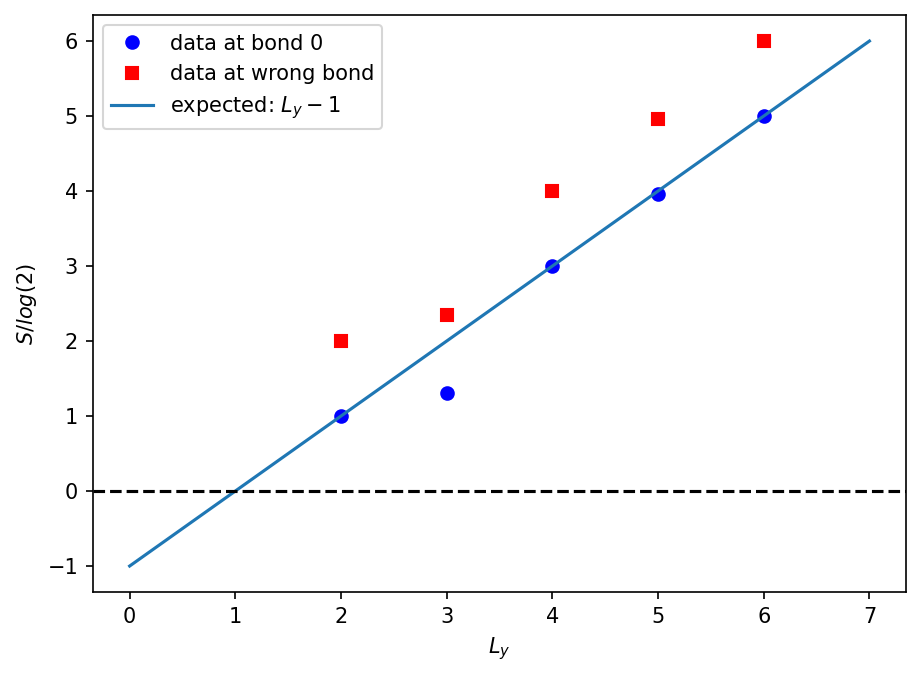

In [12]:
Lys = np.array(list(results_Ly.keys()))
S0s = np.array([res['psi'].entanglement_entropy()[0] for res in results_Ly.values()])
S1s = np.array([res['psi'].entanglement_entropy()[2] for res in results_Ly.values()])

plt.figure(figsize=(7, 5))
ax = plt.gca()
ax.plot(Lys, S0s / np.log(2), 'bo', label='data at bond 0')
ax.plot(Lys, S1s / np.log(2), 'rs', label='data at wrong bond')
Lys_all = np.arange(0., max(Lys) + 2.)
ax.plot(Lys_all, Lys_all - 1., '-', label='expected: $L_y - 1$')
ax.axhline(0., linestyle='--', color='k')
ax.set_xlabel('$L_y$')
ax.set_ylabel('$S / log(2)$')

ax.legend()
plt.show()


As expected, we find the scaling $S(L_y) = \log(2) L_y - \log(2)$ at bond 0, indicating that $\gamma = \log(2)$. 
Cutting the MPS at bond 1 (red points) is a "weird" cut of the cylinder and does not show the expected scaling.